In [1]:
import os, requests
from pathlib import Path
DATA_DIR = Path.cwd().parent / 'data'

fname = []
for j in range(3):
  fname.append(DATA_DIR / f"steinmetz_part{j}.npz")
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not fname[j].exists():
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [2]:
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load(DATA_DIR / f"steinmetz_part{j}.npz", allow_pickle=True)['dat']))

In [3]:
# I added secondary motor to selectors
with open(DATA_DIR / "selectors_BW.npy", "rb") as f:
    selectors = np.load(f, allow_pickle=True)

In [4]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

plt.style.use('fivethirtyeight')

#### Helper functions for visualization

In [5]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def traj_viz_continous(x, y, axis, name_x = 'PC 1', name_y = 'PC 2', title = 'Neural Trajectory'):
  """
  Visualize neural trajectories with continous color coding
  
  Use np.take_along_axis with spike data and returned indices
  
  Arguments:
  x -- N x 1 array of data to be plotted along the x axis
  y -- N x 1 array of data to be plotted along the y axis. 
  axis -- the axis (of subplots) to draw the figure 

  Keyword Arguments:
  name_x -- label for x axis
  name_y -- label for y axis
  title -- title
  """

  dat_len = len(x)
  t = np.arange(0, dat_len)
  col_precision = 2 # color precision: num of points that is assigned to the same color
  
  # Create a set of line segments so that we can color them individually
  points = np.array([x, y]).T.reshape(-1, 1, 2)   # reshape into  numlines x points per line x 2 (x and y)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  # Create the line collection object, setting the colormapping parameters.
  # Have to set the actual values used for colormapping separately.
  lc = LineCollection(segments, cmap=plt.get_cmap('coolwarm'),
      norm=plt.Normalize(0, dat_len/col_precision))
  lc.set_array(t)
  lc.set_linewidth(3)

  # plot the line
  axis.add_collection(lc)

  # make it a little nicer
  axis.set_xlim( np.min(x) - np.std(x)/2 , np.max(x) + np.std(x)/2 )
  axis.set_xlabel(f'{name_x}')
  axis.set_ylim( np.min(y) - np.std(y)/2 , np.max(y) + np.std(y)/2 )
  axis.set_ylabel(f'{name_y}')
  axis.set_title(f'{title}')

  axis.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False)

    #     plt.sci(line_segments)  # This allows interactive changing of the colormap.
    #   plt.arrow(x[-1], y[-1], -(x[-2]-x[-1]), -(y[-2]-y[-1]),
#             width = 0.04, shape='full', lw=0, length_includes_head=True, 
#             head_width=.04, color='k')

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm 

def add_colorbar(axis, data_len):
    axins = inset_axes(axis,
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axis.transAxes,
                   borderpad=0,
                   )
    cbar = plt.colorbar( cm.ScalarMappable(norm=plt.Normalize(0, data_len), cmap='coolwarm'), 
              ax=axis, 
              cax=axins
            )
    cbar.ax.set_ylabel(' Time (ms)')
    
def update_limits(pc_xlim, pc_ylim, xs, ys):
    pc_ylim[0] = ys[0] if pc_ylim[0] > ys[0] else pc_ylim[0]
    pc_ylim[1] = ys[1] if pc_ylim[1] < ys[1] else pc_ylim[1]
    pc_xlim[0] = xs[0] if pc_xlim[0] > xs[0] else pc_xlim[0]
    pc_xlim[1] = xs[1] if pc_xlim[1] < xs[1] else pc_xlim[1]
    
    return pc_xlim, pc_ylim

## Begin

In [7]:
# See what mouse has what areas
for i in range(len(alldat)):
    print(i)
    print(np.unique(alldat[i]['mouse_name']), np.unique(alldat[i]['brain_area']))

0
['Cori'] ['ACA' 'CA3' 'DG' 'LS' 'MOs' 'SUB' 'VISp' 'root']
1
['Cori'] ['CA1' 'POST' 'VISl' 'VISpm' 'root']
2
['Cori'] ['CA1' 'DG' 'LP' 'MG' 'MRN' 'NB' 'POST' 'SPF' 'VISam' 'VISp' 'root']
3
['Forssmann'] ['ACA' 'CA1' 'DG' 'LGd' 'LSr' 'MOs' 'SUB' 'TH' 'VISa' 'VISp' 'VPL']
4
['Forssmann'] ['ACA' 'CA1' 'DG' 'MOs' 'OLF' 'ORB' 'PL' 'SUB' 'VISa' 'root']
5
['Forssmann'] ['AUD' 'CA1' 'SSp' 'TH' 'root']
6
['Forssmann'] ['CA3' 'CP' 'EPd' 'LD' 'PIR' 'SSp' 'VPL' 'root']
7
['Hench'] ['CA1' 'CA3' 'DG' 'ILA' 'LD' 'LP' 'LSr' 'MOs' 'PL' 'PO' 'SUB' 'TT' 'VISa'
 'VISp' 'root']
8
['Hench'] ['CA1' 'CA3' 'LD' 'LSr' 'ORBm' 'PL' 'TH' 'TT' 'VISam' 'VISl' 'VPL' 'root']
9
['Hench'] ['CA1' 'DG' 'GPe' 'MB' 'MRN' 'POL' 'POST' 'SCm' 'SCsg' 'VISl' 'VISp'
 'VISrl' 'root']
10
['Hench'] ['CP' 'LSc' 'LSr' 'MOp' 'PT' 'root']
11
['Lederberg'] ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']
12
['Lederberg'] ['ACA' 'CA1' 'DG' 'LGd' 'MB' 'MOs' 'MRN' 'MS' 'PL' 'RN' 'SCm' 'SCs'
 'VISam' 'ZI' 'root']
1

### Run PCA on Primary Visual Cortex, and Secondary Motor Cortex
Good sessions to use: 7, 24, 25

In [9]:
# run pca on visual region

# Choose
sub = 24
sel = selectors[sub]
vis_dat = alldat[sub]['spks'][sel["NEURON_VISUAL"]]

print(vis_dat.shape)

%run run_PCA.ipynb
%run smt_PCA.ipynb

W, V, variance_explained = run_pca(vis_dat[:,:,51:130])

# project data to pcs
pc_10ms = map_pca(W, V, vis_dat)

# get first two mean pcs and smooth them
n = 2500
pc_smt_ = np.zeros((pc_10ms.shape[0],n))

for i in range(pc_10ms.shape[0]):
    pc_smt = smt_pca(pc_10ms[i].mean(axis = 0),n)
    pc_smt_[i,:] = pc_smt

print(pc_10ms[0][1][51:].shape)

NameError: name 'selectors' is not defined

In [41]:
def map_and_smooth(data, W, V):
    '''
        Map PCA weights to data and smooth
    '''
    # map pc
    pc_10ms = map_pca(W, V, data)

    # smooth the first two PC
    n = 2500
    pc_smt_ = np.zeros((pc_10ms.shape[0],n))    
    for i in range(pc_10ms.shape[0]):
        pc_smt = smt_pca(pc_10ms[i].mean(axis = 0),n)
        pc_smt_[i,:] = pc_smt
    
    return pc_smt_

In [8]:
# Map PCA for For vision
sel['CHOICE_INCORRECT'] = ~sel['CHOICE_CORRECT']
outcomes = ['CHOICE_CORRECT' , 'CHOICE_INCORRECT']

contrast_levels = ["STIM_RIGHT_HIGH", "STIM_RIGHT_MEDIUM", "STIM_RIGHT_LOW", "STIM_RIGHT_NONE"]

# create two dictionaries
pc_vision_correct = {}
pc_vision_incorrect = {}

for outcome in outcomes:
    # get smoothed pc components for each
    print(f'pc_vision_{outcome[7:]}'.lower())
    for contrast in contrast_levels:
        # select data
        contrast_data = vis_dat[:, sel[contrast] & sel[outcome]]
        
        # save pc in dictionary
        if outcome == 'CHOICE_CORRECT':
            pc_vision_correct[contrast] = map_and_smooth(contrast_data, W, V)
        elif outcome == "CHOICE_INCORRECT":
            pc_vision_incorrect[contrast] = map_and_smooth(contrast_data, W, V)

        print(outcome, contrast, 'shape: ', contrast_data.shape)


NameError: name 'sel' is not defined

Vision Correct Trials


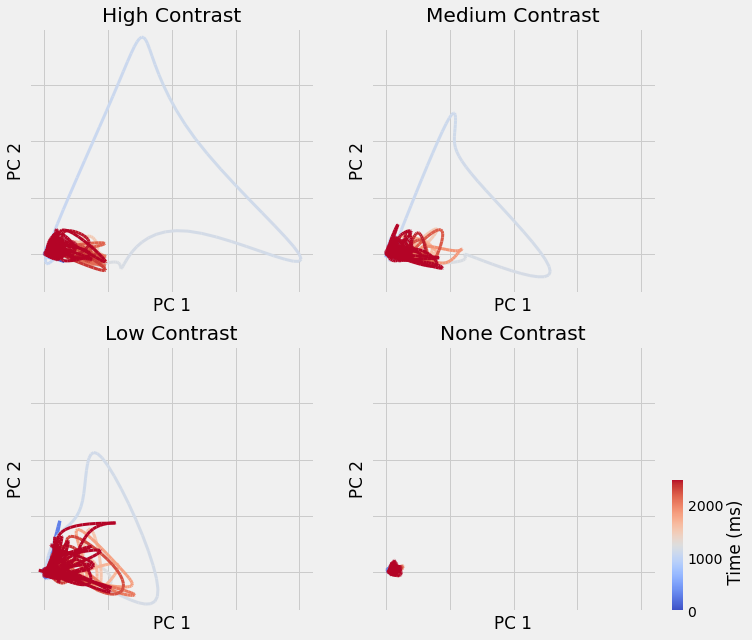

In [86]:
# Visualization for vision, correct
print('Vision Correct Trials')
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)

titles = [ word+' Contrast' for word in ['High', 'Medium', 'Low', 'None']]

# random limits to start with
pc_xlim = [0,0.5]
pc_ylim = [0,0.5]

for i, contrast in enumerate(contrast_levels):
    traj_viz_continous(pc_vision_correct[contrast][0], pc_vision_correct[contrast][1], 
                       axs[i//2, i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)
# plt.xticks(ticks=pc_xlim)
# plt.yticks(ticks=pc_ylim)

add_colorbar(axs[1,1], len(pc_vision_correct[contrast][0]))

Vision Incorrect Trials


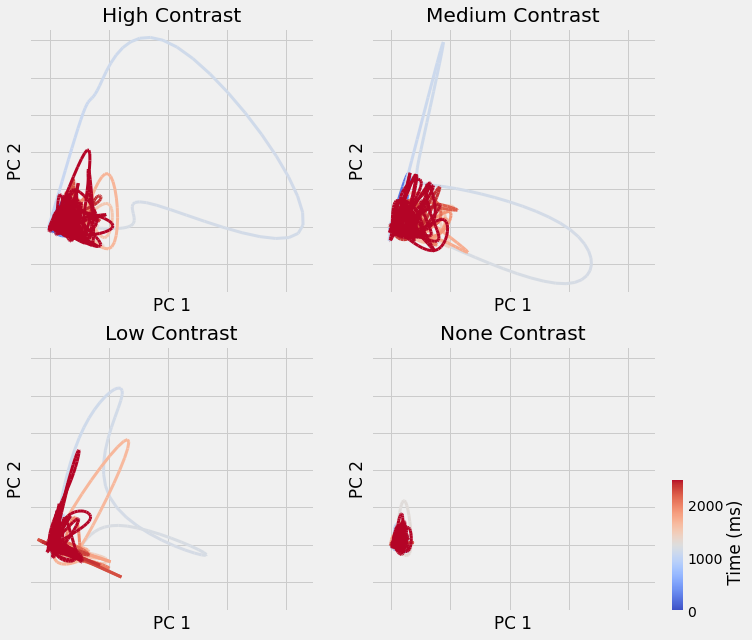

In [87]:
# Visualization for vision, incorrect
print('Vision Incorrect Trials')
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)

titles = [ word+' Contrast' for word in ['High', 'Medium', 'Low', 'None']]

# random limits to start with
pc_xlim = [0,0.5]
pc_ylim = [0,0.5]

for i, contrast in enumerate(contrast_levels):
    traj_viz_continous(pc_vision_incorrect[contrast][0], pc_vision_incorrect[contrast][1], 
                       axs[i//2, i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)
# plt.xticks(ticks=pc_xlim)
# plt.yticks(ticks=pc_ylim)

add_colorbar(axs[1,1], len(pc_vision_incorrect[contrast][0]))

### Motor Trajectories

In [9]:
# run pca on secondary motor region
mot_dat = alldat[sub]['spks'][sel["NEURON_SEC_MOTOR"]]

print(mot_dat.shape)

W_m, V_m, variance_explained_m = run_pca(mot_dat[:,:,0:200])

# project data to pcs
pc_mot = map_pca(W_m, V_m, mot_dat)

# get first two mean pcs and smooth them
n = 2500
pc_m_smt_ = np.zeros((pc_mot.shape[0],n))

for i in range(pc_mot.shape[0]):
    pc_m_smt = smt_pca(pc_mot[i].mean(axis = 0),n)
    pc_m_smt_[i,:] = pc_m_smt

print(pc_mot[0][1][51:].shape)

(80, 261, 250)
(199,)


In [90]:
# Map PCA For motor
motor_dat = alldat[sub]['spks'][sel["NEURON_SEC_MOTOR"]]
actions = ["GO_TRIALS", "NOGO_TRIALS"]
pc_motor_correct = {}
pc_motor_incorrect = {}

for outcome in outcomes:
    # get smoothed pc components for each
    print(f'pc_motor_{outcome[7:]}'.lower())

    for action in actions:
        # select data
        action_data = motor_dat[:, sel[action] & sel[outcome]]
        print(outcome, action, 'shape: ', action_data.shape)
        
        # save pc in dictionary
        if outcome == 'CHOICE_CORRECT':
            pc_motor_correct[action] = map_and_smooth(action_data, W_m, V_m)
        elif outcome == "CHOICE_INCORRECT":
            pc_motor_incorrect[action] = map_and_smooth(action_data, W_m, V_m)

pc_motor_correct
CHOICE_CORRECT GO_TRIALS shape:  (80, 161, 250)
CHOICE_CORRECT NOGO_TRIALS shape:  (80, 20, 250)
pc_motor_incorrect
CHOICE_INCORRECT GO_TRIALS shape:  (80, 57, 250)
CHOICE_INCORRECT NOGO_TRIALS shape:  (80, 23, 250)


Motor Correct Trials


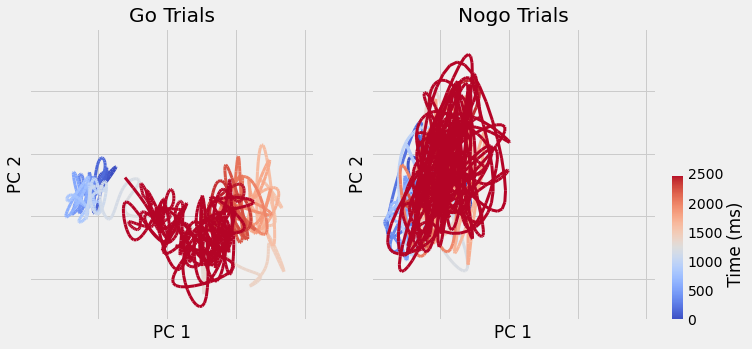

In [91]:
# for motor, correct
print('Motor Correct Trials')
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)

titles = ['Go Trials', 'Nogo Trials']

# random limits to start with
pc_xlim = [0,0.3]
pc_ylim = [0,0.3]

for i, action in enumerate(actions):
    traj_viz_continous(pc_motor_correct[action][0], pc_motor_correct[action][1], 
                       axs[i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)

add_colorbar(axs[1], len(pc_motor_correct[action][0]))

Motor Incorrect Trials


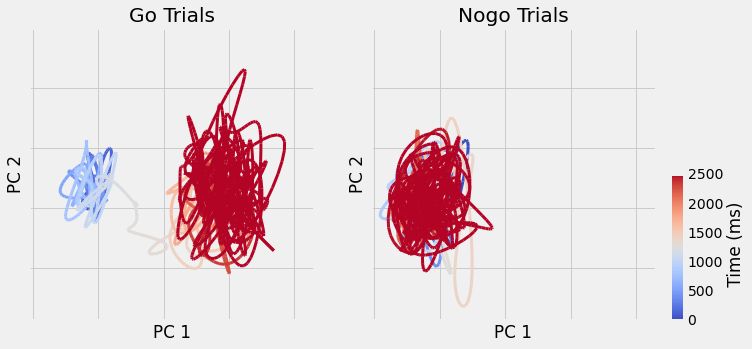

In [92]:
# for motor, incorrect
print('Motor Incorrect Trials')
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)

titles = ['Go Trials', 'Nogo Trials']

# random limits to start with
pc_xlim = [0,0.3]
pc_ylim = [0,0.3]

for i, action in enumerate(actions):
    traj_viz_continous(pc_motor_incorrect[action][0], pc_motor_incorrect[action][1], 
                       axs[i%2], 
                       name_x = 'PC 1', name_y = 'PC 2', 
                       title = titles[i])
    ys = plt.gca().get_ylim()
    xs = plt.gca().get_xlim()
    pc_xlim, pc_ylim = update_limits(pc_xlim, pc_ylim, xs, ys)

# Setting the values for all axes.
plt.setp(axs, xlim=pc_xlim, ylim=pc_ylim)

add_colorbar(axs[1], len(pc_motor_incorrect[action][0]))

### Save the data from #24

In [130]:
session24 = [vis_dat, motor_dat, W, V, W_m, V_m]

with open(DATA_DIR / "session24_data.npz", "wb") as f:

    np.savez(f, 
             vis_dat = vis_dat, 
             motor_dat = motor_dat, 
             W_v = W, 
             V_v = V, 
             W_m = W_m, 
             V_m = V_m)


In [131]:
with open(DATA_DIR / "session24_data.npz", "rb") as f:
    data = np.load(f, allow_pickle=True)
data.files

['vis_dat', 'motor_dat', 'W_v', 'V_v', 'W_m', 'V_m']

Example on how to use the function

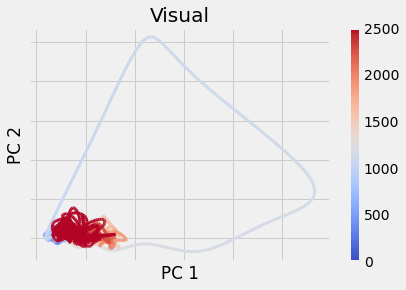

In [10]:
# this shows time trajectory over one whole trial
fig = plt.figure()
traj_viz_continous(pc_smt_[0], pc_smt_[1], plt.gca(), name_x = 'PC 1', name_y = 'PC 2', title = 'Visual')
plt.colorbar( cm.ScalarMappable(norm=plt.Normalize(0, len(pc_smt_[0])), cmap='coolwarm'), ax=plt.gca())